# <font  color = "#0093AF">Chemical Exchange Saturation Transfer (CEST)</font>

<a href="https://githubtocolab.com/alsinmr/SLEEPY_tutorial/blob/main/ColabNotebooks/Chapter2/Ch2_CEST.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg"></a>

Sometimes, a system undergoes chemical exchange, but with one large population and one very small population, such that the peak of the latter is difficult or impossible to observe directly. However, if we apply a low-power saturating field to magnetization in the z-direction, it is possible to saturate the magnetization when the applied field is on-resonant with the invisible peak. This is referred to as the Chemical Exchange Saturation Transfer experiment (CEST).$^1$ This allows us to observed "invisible" resonances in exchange with the main resonance.

[1] S. Forsén, R.A. Hoffman. [*J. Chem. Phys.*](https://doi.org/10.1063/1.1734121), **1963**, 39, 2892-2901.

## Setup

In [0]:
# SETUP SLEEPY
import sys
if 'google.colab' in sys.modules:
  !pip install sleepy-nmr

In [2]:
import SLEEPY as sl
import numpy as np
import matplotlib.pyplot as plt
sl.Defaults['verbose']=False

## Build the spin system

In [3]:
ex0=sl.ExpSys(v0H=600,Nucs='13C',T_K=298) #We need a description of the experiment for both states (ex0, ex1)
ex1=ex0.copy()
ex0.set_inter(Type='CS',i=0,ppm=-7)
_=ex1.set_inter(Type='CS',i=0,ppm=7)

## Build the Liouvillian
For CEST to work, we need to be able saturate the spins, which requires $T_2$ relaxation. For a more realistic behavior, we also include $T_1$ recovery of the magnetization, which can inhibit the saturation. Finally, we will allow the magnetization to recover towards its thermal equilibrium. These terms are all added via the `L.add_relax(...)` functionality of the Liouvillian.

In [4]:
L=sl.Liouvillian((ex0,ex1))  #Builds the two different Hamiltonians and exports them to Liouville space

tc=1e-3     #Correlation time
p1=0.95  #Population of state 1

L.kex=sl.Tools.twoSite_kex(tc=tc,p1=p1)    #Add exchange to the Liouvillian

L.add_relax(Type='T1',i=0,T1=1.5)   #Add T1 relaxation to the system
L.add_relax(Type='T2',i=0,T2=.05)             #Add T2 relaxation to the system
_=L.add_relax(Type='recovery') #This brings the spins back into thermal equilibrium

## Calculate the required propagators
We'll simulate this system by starting with magnetization along the z-axis and saturating at some frequency, which will be swept. After the saturation period, we'll apply a $\pi/2$-pulse along the y-axis to get x-magnetization. This will be allowed to evolve, and will then be Fourier transformed. We then integrate the main peak to determine the amount of saturation that has occured.

## Run the sequence, with sweep over $\nu_1$

For each offset frequency, we start with a 25 Hz saturating field for 500 ms, followed by a $\pi/2$ pulse (defined in the sequence `seq`). Then, we evolve (using the sequence `evol`) to get a spectrum (which we will later integrate the main peak)

In [5]:
rho=sl.Rho(rho0='13Cz',detect='13Cp')  #Initial density matrix

# Make a sequence for saturation
seq=L.Sequence()    #Saturation and pi/2 pulse
t=[0,0.5,0.5+2.5e-6] #Preparation sequence (500 ms saturation, 100 kHz pi-pulse)

# Make a sequence for detection
Dt=1/(4*10*150)  #Broad enough to capture 10 ppm
evol=L.Sequence(Dt=Dt) #Evolution sequence

voff0=np.linspace(-20,20,500)*ex0.v0[0]/1e6     #5 ppm*150 MHz / 1e6 =750 Hz
spec=list()
for voff in voff0:
    seq.add_channel('13C',t=t,v1=[25,100e3],
                    voff=[voff,0],phase=[0,np.pi/2])
    rho.clear()
    (seq*rho).DetProp(evol,n=1024)
    spec.append(rho.FT[0].real)

## Plot one of the spectra
We first plot a spectrum, where we observe that the weaker peak is nearly invisible (it appears if we zoom in around 5 ppm, but would be quite difficult to see in a real spectrum).

Note that later we integrate the spectrum by selecting a range of points in the spectrum. In this case, it may be useful to set `axis='points'` to more easily determine what range of points to sum over.

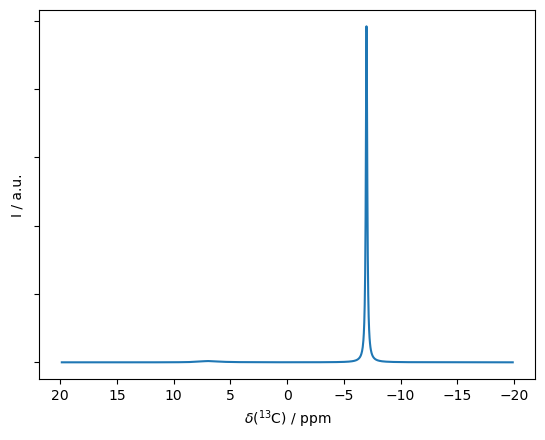

In [6]:
ax=rho.plot(FT=True,axis='ppm')
_=ax.set_yticklabels('')

## Integrate spectrum for all values of $\nu_1$ and plot results
We integrate over the strong peak and plot the peak intensity

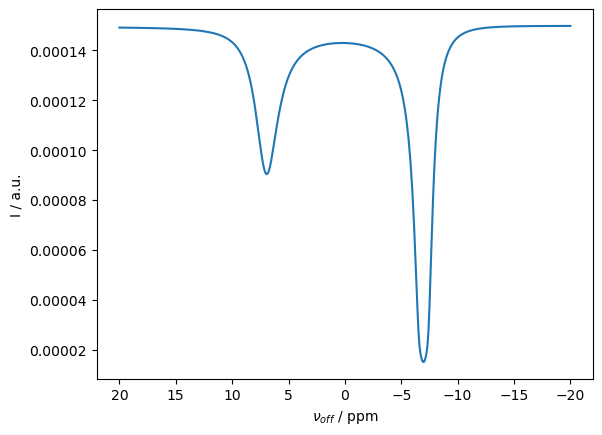

In [7]:
spec=np.array(spec)   #Convert the list of spectra to a numpy array
I=spec[:,400:620].sum(1)  #Integrate over the main peak

ax=plt.subplots()[1]
ax.plot(voff0*1e6/ex0.v0[0],I)
ax.set_xlabel(r'$\nu_{off}$ / ppm')
ax.set_ylabel('I / a.u.')
ax.invert_xaxis()

## Investigate CEST as a function of exchange rate
We repeat the above setup, while varying the exchange rate

In [8]:
p1=0.95  #Population of state 1
p2=1-p1  #Population of state 2

rho=sl.Rho(rho0='13Cz',detect='13Cp')

# Make a sequence for saturation
seq=L.Sequence()    
t=[0,0.5,0.5+2.5e-6] #Preparation sequence (500 ms saturation, 100 kHz pi-pulse)

# Make a sequence for detection
Dt=1/(4*10*150)  #Broad enough to capture 10 ppm
evol=L.Sequence(Dt=Dt) #Evolution sequence

tc0=np.logspace(0,-5.5,12)
I=list()
for tc in tc0:
    L.kex=sl.Tools.twoSite_kex(tc=tc,p1=p1)    #Add exchange to the Liouvillian
    
    voff0=np.linspace(-20,20,500)*ex0.v0[0]/1e6     #5 ppm*150 MHz / 1e6 =750 Hz
    spec=list()
    for voff in voff0:
        seq.add_channel('13C',t=t,v1=[25,100e3],
                        voff=[voff,0],phase=[0,np.pi/2])
        rho.clear()
        (seq*rho).DetProp(evol,n=1024)
        spec.append(rho.FT[0].real)

    spec=np.array(spec)   #Convert to a numpy array
    I.append(spec[:,400:620].sum(1))  #Integrate over the main peak

We plot the results below, where we see that the saturation behavior depends strongly on the exchange rate. Note that if the exchange is too fast or too slow, the CEST experiment is no longer as effective, since it either becomes difficult to saturate the main peak via the minor peak, or because the two peaks coalesce.

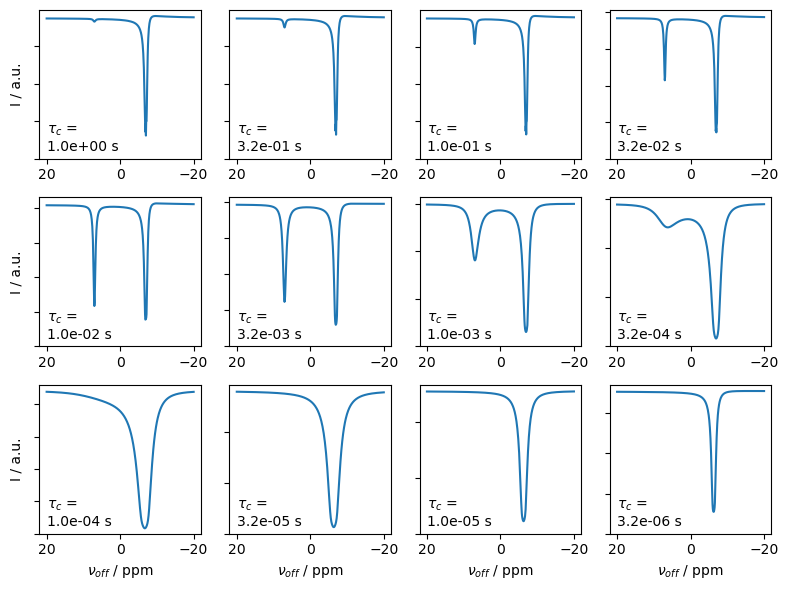

In [9]:
fig,ax=plt.subplots(3,4,figsize=[8,6])
ax=ax.reshape(ax.size)

for a,I0,tc in zip(ax,I,tc0):
    a.plot(voff0*1e6/ex0.v0[0],I0)
    if a.is_last_row():
        a.set_xlabel(r'$\nu_{off}$ / ppm')
    if a.is_first_col():
        a.set_ylabel('I / a.u.')
    a.invert_xaxis()
    a.set_yticklabels('')
    a.set_ylim([0,a.get_ylim()[1]])
    a.text(20,a.get_ylim()[1]*.05,r'$\tau_c$'+f' = \n{tc:.1e} s')
fig.tight_layout()